In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from prophet import Prophet
import pmdarima as pm
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import warnings
import joblib
warnings.filterwarnings('ignore')
np.random.seed(42)

c:\Users\ericl\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [7]:
class IntegratedForecaster:
    def __init__(self):
        self.sarima_model = None
        self.prophet_model = None
        self.base_mean = None  # Will store the mean of training data
    
    def fit(self, data):
        # Store the mean of training data for later scaling
        self.base_mean = data['MW_pattern'].mean()
        last_year = data.index.max().year
        data_subset = data[data.index.year == last_year]
        # Train Sarima on normalized data
        self.sarima_model = pm.auto_arima(
            data_subset['MW_pattern'],
            seasonal=True,
            m=24,
            D=1,
            start_p=1, max_p=3,
            start_q=1, max_q=3,
            start_P=1, max_P=2,
            start_Q=1, max_Q=2,
            information_criterion='aic',
            trace=True,           
            error_action='warn',  
            suppress_warnings=True,
            stepwise=True,
            n_jobs=-1
        )
        
        # Prepare data for Prophet
        df_prophet = pd.DataFrame({
            'ds': data.index,
            'y': data['MW_pattern']
        })
        
        self.prophet_model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=True,
            seasonality_mode='multiplicative'
        )
        self.prophet_model.fit(df_prophet)

    def predict(self, base_load, start_datetime, end_datetime):
        """
        Generate predictions for the specified datetime range.
        
        Parameters:
        -----------
        base_load : float or int
            Base load value used for scaling predictions
        start_datetime : str or datetime
            Start date and time for predictions
        end_datetime : str or datetime
            End date and time for predictions
            
        Returns:
        --------
        pandas.Series
            Hourly predictions with datetime index
            
        Raises:
        -------
        ValueError
            If base_load is not positive or start_datetime is after end_datetime
        """
        # Input validation
        if not isinstance(base_load, (int, float)) or base_load <= 0:
            raise ValueError("base_load must be a positive number")
            
        # Convert strings to datetime if necessary
        if isinstance(start_datetime, str):
            start_datetime = pd.to_datetime(start_datetime)
        if isinstance(end_datetime, str):
            end_datetime = pd.to_datetime(end_datetime)
            
        if start_datetime >= end_datetime:
            raise ValueError("start_datetime must be before end_datetime")
        
        # Create datetime range
        date_range = pd.date_range(
            start=start_datetime,
            end=end_datetime,
            freq='H'
        )
        
        # Get SARIMA predictions
        sarima_forecast = self.sarima_model.predict(n_periods=len(date_range))
        
        # Get Prophet predictions
        future_prophet = pd.DataFrame({'ds': date_range})
        prophet_forecast = self.prophet_model.predict(future_prophet)
        
        # Combine predictions with weights (still normalized)
        combined_forecast = (
            1 * prophet_forecast['yhat'].values +
            0 * sarima_forecast
        )
        
        # Calculate scaling factor
        scaling_factor = base_load / self.base_mean
        
        # Scale the combined forecast
        scaled_values = np.array(combined_forecast) * scaling_factor
        
        # Create final predictions series
        predictions = pd.Series(
            data=scaled_values,
            index=date_range,
            name='predicted_MWh'
        )
        
        return predictions

    def load_models(self, filename='forecaster_models.joblib'):
        """Load saved SARIMA and Prophet models along with base_mean"""
        model_data = joblib.load(filename)
        self.sarima_model = model_data['sarima_model']
        self.prophet_model = model_data['prophet_model']
        self.base_mean = model_data['base_mean']
        print("Models loaded successfully")
    def save_models(self, filename='forecaster_models.joblib'):
        """Save SARIMA and Prophet models along with base_mean"""
        joblib.dump({
        'sarima_model': self.sarima_model,
        'prophet_model': self.prophet_model,
        'base_mean': self.base_mean
        }, filename)
        print("Models saved successfully")

In [8]:

if __name__ == "__main__":
    # Load and train model on combined dataset
    training_data = pd.read_csv('combined_utility_data_with_MW_pattern.csv')
    training_data['Datetime'] = pd.to_datetime(training_data['Datetime'])
    training_data.set_index('Datetime', inplace=True)
    
    # Train the forecaster
    forecaster = IntegratedForecaster()
    forecaster.load_models()
    # Test period in 2017
    test_start = '2017-01-01 00:00'
    test_end = '2017-12-31 23:00'
    
    # utility files
    utility_files = {
        'AEP': 'AEP_hourly.csv',
        'COMED': 'COMED_hourly.csv',
        'DAYTON': 'DAYTON_hourly.csv',
        'DEOK': 'DEOK_hourly.csv',
        'DOM': 'DOM_hourly.csv',
        'DUQ': 'DUQ_hourly.csv',
        'EKPC': 'EKPC_hourly.csv',
        'FE': 'FE_hourly.csv',
        'PJME': 'PJME_hourly.csv',
        'PJMW': 'PJMW_hourly.csv'
    }
    
    # Test on each utility
    for name, file in utility_files.items():
        # Load utility data
        df = pd.read_csv(file)
        df['Datetime'] = pd.to_datetime(df['Datetime'])
        df.set_index('Datetime', inplace=True)
        
        # Get test period data
        mask = (df.index >= test_start) & (df.index <= test_end)
        test_data = df.loc[mask]
        
        # Calculate base load (average MW for 2016)
        year_mask = df.index.year == 2016
        base_load = df[f'{name}_MW'][year_mask].mean()
        
        # Get predictions
        predictions = forecaster.predict(
            base_load=base_load,
            start_datetime=test_start,
            end_datetime=test_end
        )
        # Calculate error metrics
        mape = mean_absolute_percentage_error(test_data[f'{name}_MW'], predictions)
        rmse = np.sqrt(mean_squared_error(test_data[f'{name}_MW'], predictions))
        
        print(f"\nResults for {name}:")
        print(f"Base Load (2017 average): {base_load:.2f} MW")
        print(f"MAPE: {mape:.2%}")
        print(f"RMSE: {rmse:.2f} MW")

Models loaded successfully

Results for AEP:
Base Load (2017 average): 14784.23 MW
MAPE: 11.49%
RMSE: 2062.31 MW

Results for COMED:
Base Load (2017 average): 11434.25 MW
MAPE: 12.81%
RMSE: 1843.35 MW

Results for DAYTON:
Base Load (2017 average): 2029.29 MW
MAPE: 12.57%
RMSE: 306.58 MW

Results for DEOK:
Base Load (2017 average): 3144.22 MW
MAPE: 13.14%
RMSE: 491.06 MW

Results for DOM:
Base Load (2017 average): 11142.32 MW
MAPE: 14.84%
RMSE: 2055.16 MW

Results for DUQ:
Base Load (2017 average): 1596.66 MW
MAPE: 12.39%
RMSE: 239.86 MW

Results for EKPC:
Base Load (2017 average): 1467.90 MW
MAPE: 16.91%
RMSE: 303.53 MW

Results for FE:
Base Load (2017 average): 7803.31 MW
MAPE: 11.59%
RMSE: 1098.18 MW

Results for PJME:
Base Load (2017 average): 31337.83 MW
MAPE: 13.82%
RMSE: 5195.04 MW

Results for PJMW:
Base Load (2017 average): 5577.93 MW
MAPE: 12.04%
RMSE: 828.42 MW


# visualization

Models loaded successfully


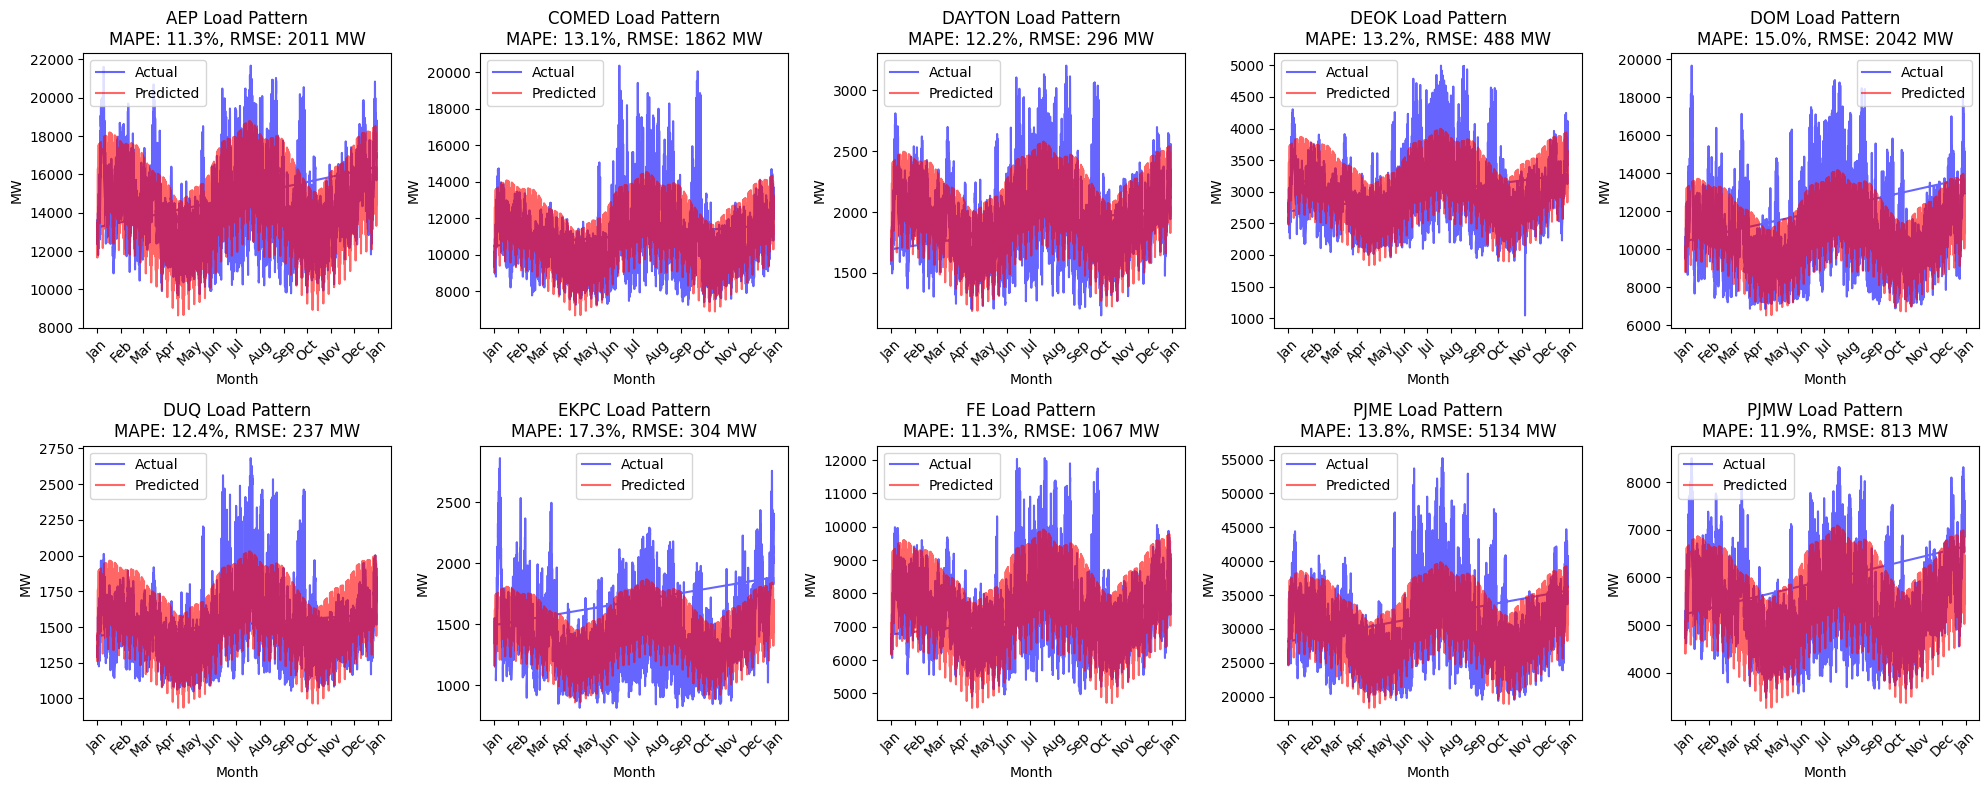

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

def plot_sarima_prophet_results(forecaster, test_start='2017-01-01', test_end='2017-12-31', base_year=2016):
    utility_files = {
        'AEP': 'AEP_hourly.csv',
        'COMED': 'COMED_hourly.csv',
        'DAYTON': 'DAYTON_hourly.csv',
        'DEOK': 'DEOK_hourly.csv',
        'DOM': 'DOM_hourly.csv',
        'DUQ': 'DUQ_hourly.csv',
        'EKPC': 'EKPC_hourly.csv',
        'FE': 'FE_hourly.csv',
        'PJME': 'PJME_hourly.csv',
        'PJMW': 'PJMW_hourly.csv'
    }
    
    # Create subplot grid
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    for idx, (utility, filename) in enumerate(utility_files.items()):
        # Read utility data
        df = pd.read_csv(filename)
        df['Datetime'] = pd.to_datetime(df['Datetime'])
        mw_col = f'{utility}_MW'
        
        # Filter to test period
        test_mask = (df['Datetime'] >= test_start) & (df['Datetime'] <= test_end)
        test_data = df[test_mask].copy()
        
        # Calculate base load
        base_data = df[df['Datetime'].dt.year == base_year]
        base_load = base_data[mw_col].mean()
        
        # Get predictions using the IntegratedForecaster
        predictions = forecaster.predict(
            base_load=base_load,
            start_datetime=test_start,
            end_datetime=test_end
        )
        
        # Plot actual vs predicted
        axes[idx].plot(test_data['Datetime'], test_data[mw_col], 'b-', label='Actual', alpha=0.6)
        axes[idx].plot(predictions.index, predictions.values, 'r-', label='Predicted', alpha=0.6)
        
        # Format plot
        axes[idx].set_title(f'{utility} Load Pattern')
        axes[idx].set_xlabel('Month')
        axes[idx].set_ylabel('MW')
        axes[idx].legend()
        
        # Format x-axis
        axes[idx].xaxis.set_major_locator(MonthLocator())
        axes[idx].xaxis.set_major_formatter(DateFormatter('%b'))
        plt.setp(axes[idx].xaxis.get_majorticklabels(), rotation=45)
        
        # Calculate and add metrics to title
        mape = mean_absolute_percentage_error(test_data[mw_col], predictions) * 100
        rmse = np.sqrt(mean_squared_error(test_data[mw_col], predictions))
        axes[idx].set_title(f'{utility} Load Pattern\nMAPE: {mape:.1f}%, RMSE: {rmse:.0f} MW')
    
    plt.tight_layout()
    plt.show()

# Load the pre-trained forecaster
forecaster = IntegratedForecaster()
forecaster.load_models()  # Load saved models

# Create visualization
plot_sarima_prophet_results(forecaster)